In [14]:
%reload_ext autoreload
%autoreload 2
import os
from pathlib import Path
import numpy as np
import pandas as pd
from aldiscore.prediction import utils
from aldiscore import ROOT, RSTATE
import matplotlib.pyplot as plt
import seaborn as sn
from collections import defaultdict
from sklearn.model_selection import train_test_split
import lightgbm as lgb

In [15]:
data_dir = Path("/hits/fast/cme/bodynems/data/paper")
param_df = pd.read_parquet(ROOT / "optuna" / "trial_03.parquet")
params = dict(param_df.drop("score", axis=1).iloc[0])
params["n_estimators"] = 1500
params["n_jobs"] = 3

In [16]:
feat_df, drop_df, label_df = utils.load_features(
    data_dir,
    label_scale="auto",
    exclude_features=["is_dna", "num_seqs", "seq_length"],
)
clean_feat_names = feat_df.columns.str.replace(":", ".").to_list()
feat_df.columns = clean_feat_names

sources = feat_df.index.get_level_values("source").unique()
idx_map = defaultdict(dict)
for source in sources:
    idx_map[source]["excl"] = feat_df.query(f"source != '{source}'").index.copy()
    idx_map[source]["incl"] = feat_df.query(f"source == '{source}'").index.copy()

Dropping 0 NaN rows...


In [17]:
sort_cols = [
    "sabre",
    "formatt_homstrad",
    "bali3",
    "prefab4",
    "ox",
    "treebase_v1",
    "bralibase_k5",
    "bralibase_k7",
    "bralibase_k15",
    "bali2dnaf",
    "bali2dna",
    "formatt_sabmark",
    "arthropod",
]
print_cols = ["is_dna", "num_seqs", "max.seq_length"]
stat_df = drop_df.groupby(["source"]).median().loc[sort_cols, print_cols].astype(int)
stat_df["is_dna"] = stat_df["is_dna"].map({0: "AA", 1: "DNA"})
stat_df = stat_df.rename({"is_dna": "dtype"}, axis=1)
stat_df.loc[sort_cols]

,dtype,num_seqs,max.seq_length
source,,,
sabre,AA,4,176
formatt_homstrad,AA,4,166
bali3,AA,18,415
prefab4,AA,50,259
ox,AA,4,124
treebase_v1,DNA,59,1438
bralibase_k5,DNA,5,86
bralibase_k7,DNA,7,87
bralibase_k15,DNA,15,87


In [18]:
print("Median difficulty per group:")
label_df.groupby(
    label_df.index.get_level_values("source"), observed=False
).median().sort_values("mean").round(2).iloc[::-1]

Median difficulty per group:


,mean
source,
formatt_sabmark,0.74
sabre,0.42
bali2dnaf,0.34
bali2dna,0.32
bali3,0.24
prefab4,0.14
formatt_homstrad,0.11
bralibase_k5,0.06
bralibase_k7,0.04


#### Study 1
Train on all but one source, predict remaining. This allows us to explore distribution similarity of the sources. 

Results
- Result: TreeBASE is clearly very different from the others (no surprise there). 
- CAREFUL: TreeBASE has a lot of very easy datasets, hence the RMSE (absolute) is good but e.g. Pearson Corr. is bad. 


In [19]:
perf_dfs = []
for source, idxs in idx_map.items():
    X_train = feat_df.loc[idxs["excl"]]
    y_train = label_df.loc[idxs["excl"]]
    X_test = feat_df.loc[idxs["incl"]]
    y_test = label_df.loc[idxs["incl"]].iloc[:, 0]
    # print(X_train.shape, X_test.shape)
    # Train the model
    model = lgb.LGBMRegressor(**params, random_state=0)
    model = model.fit(X_train, y_train)
    eps = 1e-2
    perf_df = utils.compute_metrics(model, X_test, y_test, eps)
    perf_df["n"] = len(y_train)
    perf_dfs.append(perf_df)

perf_df = pd.concat(perf_dfs, axis=0, ignore_index=True)
perf_df.index = list(idx_map.keys())
perf_df = perf_df.sort_values("CORR", ascending=False)
perf_df

,RMSE,RMSE_CV,MAE,MAPE,MAPE_P50,CORR,n
bali2dnaf,0.0271,0.0682,0.0201,0.0673,0.0424,0.9939,11290
bali2dna,0.0302,0.0764,0.0211,0.0777,0.0418,0.9929,11290
bralibase_k15,0.0286,0.2466,0.0164,0.1926,0.1314,0.9795,10928
sabre,0.0583,0.1362,0.0384,0.1536,0.0587,0.9721,11008
formatt_sabmark,0.0660,0.0948,0.0445,0.0619,0.0325,0.9670,11222
bralibase_k7,0.0442,0.3435,0.0258,0.2546,0.1638,0.9585,10005
ox,0.0463,0.4636,0.0272,0.5090,0.3017,0.9527,11036
bali3,0.0587,0.2095,0.0398,0.1496,0.1178,0.9526,11045
bralibase_k5,0.0573,0.4218,0.0352,0.4448,0.2389,0.9351,9026
arthropod,0.0121,0.3083,0.0085,0.1767,0.1527,0.9267,11150


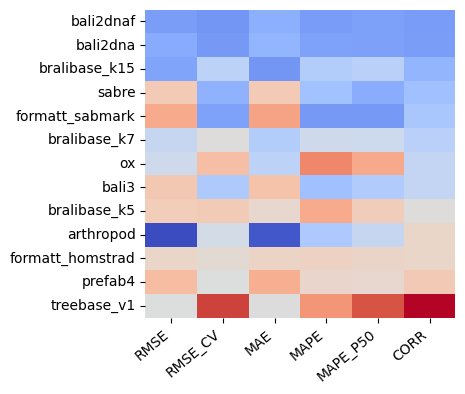

In [20]:
stats = perf_df.map(float).drop("n", axis=1)
stats["CORR"] = 1 - stats["CORR"]
stats = (stats - stats.mean(axis=0)) / stats.std(axis=0)
fig = plt.figure(figsize=(4, 4))
sn.heatmap(stats, cmap="coolwarm", cbar=False)
_ = fig.gca().set_xticklabels(fig.gca().get_xticklabels(), rotation=40, ha="right")

#### Study 2
Train on one source, predict all others. This allows us to assess the diversity of the data per source.

Results
- Result: SABRE seems to be the most diverse in terms of being able to predict the others.
- CAREFUL: some sources contain a lot more datasets than others, which may skew the results.

In [21]:
perf_dfs = []
for source, idxs in idx_map.items():
    X_train = feat_df.loc[idxs["incl"]]
    y_train = label_df.loc[idxs["incl"]]
    X_test = feat_df.loc[idxs["excl"]]
    y_test = label_df.loc[idxs["excl"]].iloc[:, 0]
    # print(X_train.shape, X_test.shape)
    # Train the model
    model = lgb.LGBMRegressor(**params, random_state=0)
    model = model.fit(X_train, y_train)
    eps = 1e-2
    perf_df = utils.compute_metrics(model, X_test, y_test, eps)
    perf_df["n"] = len(y_train)
    perf_dfs.append(perf_df)

perf_df = pd.concat(perf_dfs, axis=0, ignore_index=True)
perf_df.index = list(idx_map.keys())
perf_df = perf_df.sort_values("CORR", ascending=False)
perf_df

,RMSE,RMSE_CV,MAE,MAPE,MAPE_P50,CORR,n
sabre,0.0687,0.4841,0.0468,0.9725,0.3582,0.9188,423
ox,0.0830,0.5377,0.0565,1.0386,0.3663,0.9022,395
formatt_homstrad,0.0815,0.5344,0.0529,0.8728,0.3529,0.9001,326
treebase_v1,0.0921,0.5034,0.0644,1.2330,0.3502,0.8971,3119
bali3,0.0969,0.6547,0.0727,1.8984,0.6404,0.8934,386
bralibase_k5,0.0895,0.5704,0.0602,0.6743,0.4271,0.8903,2405
prefab4,0.0932,0.6320,0.0570,0.9490,0.3861,0.8840,1676
bralibase_k7,0.0981,0.6288,0.0640,0.8242,0.4231,0.8607,1426
bali2dnaf,0.1034,0.6920,0.0831,2.4105,0.7587,0.8595,141
bali2dna,0.1160,0.7762,0.0972,2.8334,1.0685,0.8391,141


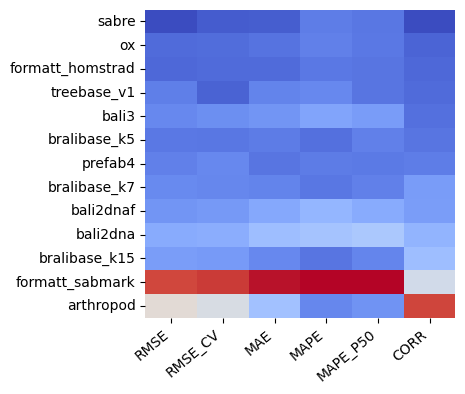

In [22]:
stats = perf_df.map(float).drop("n", axis=1)
stats["CORR"] = 1 - stats["CORR"]
stats = (stats - stats.mean(axis=0)) / stats.std(axis=0)
fig = plt.figure(figsize=(4, 4))
sn.heatmap(stats, cmap="coolwarm", cbar=False)
_ = fig.gca().set_xticklabels(fig.gca().get_xticklabels(), rotation=40, ha="right")